In [1]:
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchinfo
from torchlake.few_shot.datasets.omniglot import OmniglotSet, TRAIN_LANGUAGES, TEST_LANGUAGES
from torchlake.few_shot.models.prototypical import (
    PrototypicalNet,
    PrototypicalNetLoss,
)
from torchvision.transforms import v2
import torchvision.transforms.functional as F
from torchlake.few_shot.controllers.trainer_episode import EpisodeTrainer
from torchlake.few_shot.controllers.evaluator_episode import EpisodeEvaluator
from torchlake.common.controller.recorder import TrainRecorder

# Setting

In [2]:
EPISODE_SIZE = 1000
IMAGE_SIZE = 28

In [3]:
artifact_path = Path('../../artifacts/prototypical')
data_path = Path('../../data')

In [4]:
DEVICE = torch.device("cuda:0")

# Data

In [5]:
TRAIN_LANGUAGES

('Alphabet_of_the_Magi',
 'Anglo-Saxon_Futhorc',
 'Arcadian',
 'Armenian',
 'Asomtavruli_(Georgian)',
 'Balinese',
 'Bengali',
 'Blackfoot_(Canadian_Aboriginal_Syllabics)',
 'Braille',
 'Burmese_(Myanmar)',
 'Cyrillic',
 'Early_Aramaic',
 'Futurama',
 'Grantha',
 'Greek',
 'Gujarati',
 'Hebrew',
 'Inuktitut_(Canadian_Aboriginal_Syllabics)',
 'Japanese_(hiragana)',
 'Japanese_(katakana)',
 'Korean',
 'Latin',
 'Malay_(Jawi_-_Arabic)',
 'Mkhedruli_(Georgian)',
 'N_Ko',
 'Ojibwe_(Canadian_Aboriginal_Syllabics)',
 'Sanskrit',
 'Syriac_(Estrangelo)',
 'Tagalog',
 'Tifinagh')

In [6]:
# TRAIN_RATIO = 0.7

In [7]:
# train_languages_set = set(np.random.choice(TRAIN_LANGUAGES, int(len(TRAIN_LANGUAGES) * TRAIN_RATIO), replace=False).tolist())
# test_languages_set = set(TRAIN_LANGUAGES).difference(train_languages_set)

In [8]:
# frozen for the last training

# train_languages_set = set((
#     "Mkhedruli_(Georgian)",
#     "Gujarati",
#     "Sanskrit",
#     "Arcadian",
#     "N_Ko",
#     "Balinese",
#     "Malay_(Jawi_-_Arabic)",
#     "Early_Aramaic",
#     "Inuktitut_(Canadian_Aboriginal_Syllabics)",
#     "Latin",
#     "Burmese_(Myanmar)",
#     "Anglo-Saxon_Futhorc",
#     "Blackfoot_(Canadian_Aboriginal_Syllabics)",
#     "Asomtavruli_(Georgian)",
#     "Armenian",
#     "Hebrew",
#     "Braille",
#     "Alphabet_of_the_Magi",
#     "Grantha",
#     "Syriac_(Estrangelo)",
#     "Greek",
# ))
# test_languages_set = set(TRAIN_LANGUAGES).difference(train_languages_set)

In [9]:
preprocess = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # lambda x: F.rotate(x, random.choice(range(0, 360, 90))),
    v2.ToTensor(),
])

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [10]:
train_dataset = OmniglotSet(
    data_path,
    train=True,
    transform=preprocess,
    enable_episode=True,
    way_size=5,
    shot_size=5,
    query_size=15,
    episode_size=EPISODE_SIZE,
    target_label="multiclass",
    label="idx",
)

In [11]:
print(f"{'lang':>50}   char count")
print("-" * 80)
for lang, chars in train_dataset.lang_chars.items():
    print(f"{lang:>50}   {len(chars)}")

                                              lang   char count
--------------------------------------------------------------------------------
                              Alphabet_of_the_Magi   20
                               Anglo-Saxon_Futhorc   29
                                          Arcadian   26
                                          Armenian   41
                            Asomtavruli_(Georgian)   40
                                          Balinese   24
                                           Bengali   46
         Blackfoot_(Canadian_Aboriginal_Syllabics)   14
                                           Braille   26
                                 Burmese_(Myanmar)   34
                                          Cyrillic   33
                                     Early_Aramaic   22
                                          Futurama   26
                                           Grantha   43
                                             Greek   24
               

# model

In [12]:
model = PrototypicalNet(1, hidden_dim=64, num_layer=4).to(DEVICE)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
PrototypicalNet                          --
├─Sequential: 1-1                        --
│    └─Conv2dNormActivation: 2-1         --
│    │    └─Conv2d: 3-1                  576
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    └─MaxPool2d: 2-2                    --
├─Sequential: 1-2                        --
│    └─Conv2dNormActivation: 2-3         --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    │    └─ReLU: 3-6                    --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2dNormActivation: 2-5         --
│    │    └─Conv2d: 3-7                  36,864
│    │    └─BatchNorm2d: 3-8             128
│    │    └─ReLU: 3-9                    --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2dNormActivation: 2-7         --
│    │    └─Conv2d: 3-10                 36,864
│    │    └─BatchNorm2d: 3-11            128
│    │    

# training

In [14]:
EPOCH = 30

In [15]:
trainer = EpisodeTrainer()

In [16]:
recorder = TrainRecorder(total_epoch=EPOCH)
recorder.increment_data_size(EPISODE_SIZE)

In [17]:
criterion = PrototypicalNetLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [18]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [19]:
training_loss = trainer.run(
    train_dataset,
    model,
    optimizer,
    criterion,
    recorder=recorder,
    scheduler=scheduler,
)

Enable AMP: False
Training...


100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]


------------------------------------
Epoch 1
------------------------------------
total: 8.3243e-02 (0.00%)


100%|██████████| 1000/1000 [01:15<00:00, 13.17it/s]


------------------------------------
Epoch 2
------------------------------------
total: 3.3698e-02 (-60.00%)


100%|██████████| 1000/1000 [01:16<00:00, 13.11it/s]


------------------------------------
Epoch 3
------------------------------------
total: 2.2022e-02 (-35.00%)


100%|██████████| 1000/1000 [01:16<00:00, 13.13it/s]


------------------------------------
Epoch 4
------------------------------------
total: 2.4028e-02 (9.00%)


100%|██████████| 1000/1000 [01:22<00:00, 12.10it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.7912e-02 (-25.00%)


100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.4667e-02 (-18.00%)


100%|██████████| 1000/1000 [01:21<00:00, 12.27it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.5123e-02 (3.00%)


100%|██████████| 1000/1000 [01:11<00:00, 13.93it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.5924e-02 (5.00%)


100%|██████████| 1000/1000 [01:12<00:00, 13.79it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.5295e-02 (-4.00%)


100%|██████████| 1000/1000 [01:36<00:00, 10.40it/s]


------------------------------------
Epoch 10
------------------------------------
total: 1.3524e-02 (-12.00%)


100%|██████████| 1000/1000 [01:23<00:00, 12.04it/s]


------------------------------------
Epoch 11
------------------------------------
total: 1.3723e-02 (1.00%)


100%|██████████| 1000/1000 [01:15<00:00, 13.28it/s]


------------------------------------
Epoch 12
------------------------------------
total: 1.4148e-02 (3.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.63it/s]


------------------------------------
Epoch 13
------------------------------------
total: 1.2524e-02 (-11.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.61it/s]


------------------------------------
Epoch 14
------------------------------------
total: 1.2031e-02 (-4.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.62it/s]


------------------------------------
Epoch 15
------------------------------------
total: 1.2340e-02 (3.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.61it/s]


------------------------------------
Epoch 16
------------------------------------
total: 1.2943e-02 (5.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.57it/s]


------------------------------------
Epoch 17
------------------------------------
total: 1.6531e-02 (28.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.62it/s]


------------------------------------
Epoch 18
------------------------------------
total: 1.1254e-02 (-32.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.66it/s]


------------------------------------
Epoch 19
------------------------------------
total: 1.1944e-02 (6.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.66it/s]


------------------------------------
Epoch 20
------------------------------------
total: 1.1669e-02 (-2.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.65it/s]


------------------------------------
Epoch 21
------------------------------------
total: 1.0426e-02 (-11.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.66it/s]


------------------------------------
Epoch 22
------------------------------------
total: 1.4805e-02 (42.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.60it/s]


------------------------------------
Epoch 23
------------------------------------
total: 1.1963e-02 (-19.00%)


100%|██████████| 1000/1000 [01:13<00:00, 13.67it/s]


------------------------------------
Epoch 24
------------------------------------
total: 9.9052e-03 (-17.00%)


100%|██████████| 1000/1000 [01:12<00:00, 13.82it/s]


------------------------------------
Epoch 25
------------------------------------
total: 1.1651e-02 (18.00%)


100%|██████████| 1000/1000 [01:12<00:00, 13.72it/s]


------------------------------------
Epoch 26
------------------------------------
total: 1.2017e-02 (3.00%)


100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]


------------------------------------
Epoch 27
------------------------------------
total: 1.1086e-02 (-8.00%)


100%|██████████| 1000/1000 [01:22<00:00, 12.15it/s]


------------------------------------
Epoch 28
------------------------------------
total: 1.2923e-02 (17.00%)


100%|██████████| 1000/1000 [01:21<00:00, 12.33it/s]


------------------------------------
Epoch 29
------------------------------------
total: 9.5750e-03 (-26.00%)


100%|██████████| 1000/1000 [01:20<00:00, 12.37it/s]

------------------------------------
Epoch 30
------------------------------------
total: 6.8672e-03 (-28.00%)


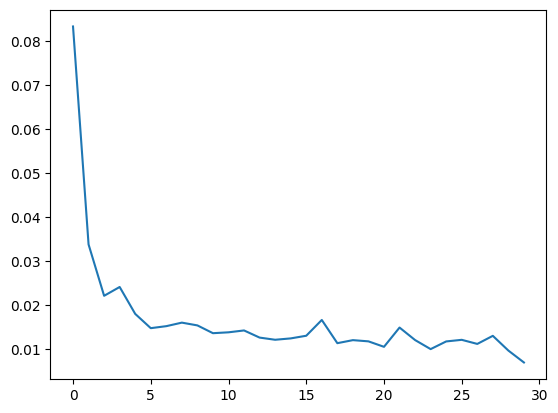

In [20]:
plt.plot(training_loss)

In [ ]:
model_path = artifact_path / 'prototypical.pth'

In [ ]:
torch.save(model.state_dict(), model_path)

# evaluation

In [16]:
model_path = artifact_path / 'prototypical.pth'

In [17]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
TEST_EPISODE_SIZE = 600

In [19]:
test_preprocess = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToTensor(),
])

## 5-way

### 1 shot

In [23]:
test_dataset = OmniglotSet(
    data_path,
    train=False,
    transform=test_preprocess,
    enable_episode=True,
    way_size=5,
    shot_size=1,
    query_size=1,
    episode_size=TEST_EPISODE_SIZE,
)

In [24]:
evaluator = EpisodeEvaluator(5, DEVICE, reduction="min")
confusion_matrix = evaluator.run(test_dataset, model)
evaluator.get_total_accuracy(confusion_matrix)

100%|██████████| 600/600 [01:03<00:00,  9.49it/s]


array(0.96433333)

### 5 shot

In [25]:
test_dataset = OmniglotSet(
    data_path,
    train=False,
    transform=test_preprocess,
    enable_episode=True,
    way_size=5,
    shot_size=5,
    query_size=1,
    episode_size=TEST_EPISODE_SIZE,
)

In [26]:
evaluator = EpisodeEvaluator(5, DEVICE, reduction="min")
confusion_matrix = evaluator.run(test_dataset, model)
evaluator.get_total_accuracy(confusion_matrix)

100%|██████████| 600/600 [01:00<00:00,  9.89it/s]


array(0.98833333)

## all chars

In [20]:
WAY_SIZE = len(OmniglotSet(data_path, train=False, languages=TEST_LANGUAGES).char_paths)
WAY_SIZE

659

In [21]:
test_dataset = OmniglotSet(
    data_path,
    train=False,
    languages=TEST_LANGUAGES,
    transform=test_preprocess,
    enable_episode=True,
    way_size=WAY_SIZE,
    shot_size=5,
    query_size=1,
    episode_size=TEST_EPISODE_SIZE,
)

In [22]:
print(f"{'lang':>50}   char count")
print("-" * 80)
for lang, chars in test_dataset.lang_chars.items():
    print(f"{lang:>50}   {len(chars)}")

                                              lang   char count
--------------------------------------------------------------------------------
                                           Angelic   20
                                Atemayar_Qelisayer   26
                                         Atlantean   26
                                        Aurek-Besh   26
                                            Avesta   26
                                             Ge_ez   26
                                        Glagolitic   45
                                          Gurmukhi   45
                                           Kannada   41
                                             Keble   26
                                         Malayalam   47
                                          Manipuri   40
                                         Mongolian   30
                    Old_Church_Slavonic_(Cyrillic)   45
                                             Oriya   46
               

In [23]:
evaluator = EpisodeEvaluator(WAY_SIZE, DEVICE, reduction="min")
confusion_matrix = evaluator.run(test_dataset, model)
evaluator.get_total_accuracy(confusion_matrix)

100%|██████████| 600/600 [21:31<00:00,  2.15s/it]


array(0.51562721)

## per language

### 1 shot

In [40]:
accs = []

In [41]:
for lang in TEST_LANGUAGES:
    WAY_SIZE = len(OmniglotSet(data_path, train=False, languages=lang).char_paths)

    test_dataset = OmniglotSet(
        data_path,
        train=False, 
        languages=lang,
        transform=test_preprocess,
        enable_episode=True,
        way_size=WAY_SIZE,
        shot_size=1,
        query_size=1,
        episode_size=TEST_EPISODE_SIZE,
    )

    evaluator = EpisodeEvaluator(WAY_SIZE, DEVICE, reduction="min")
    confusion_matrix = evaluator.run(test_dataset, model)
    acc = evaluator.get_total_accuracy(confusion_matrix)
    accs.append(acc)

100%|██████████| 600/600 [00:22<00:00, 26.12it/s]


In [42]:
np.mean(accs)

np.float64(0.4910828899531956)

In [43]:
print(f"{'lang':>50}   acc")
print("-" * 80)
for lang, acc in zip(TEST_LANGUAGES, accs):
    print(f"{lang:>50}   {acc.round(4)}")

                                              lang   acc
--------------------------------------------------------------------------------
                                           Angelic   0.5589
                                Atemayar_Qelisayer   0.4912
                                         Atlantean   0.5402
                                        Aurek-Besh   0.5864
                                            Avesta   0.5076
                                             Ge_ez   0.5171
                                        Glagolitic   0.4953
                                          Gurmukhi   0.4396
                                           Kannada   0.3948
                                             Keble   0.569
                                         Malayalam   0.4301
                                          Manipuri   0.5094
                                         Mongolian   0.5353
                    Old_Church_Slavonic_(Cyrillic)   0.5334
                       

### 5 shot

In [45]:
accs = []

In [46]:
for lang in TEST_LANGUAGES:
    WAY_SIZE = len(OmniglotSet(data_path, train=False, languages=lang).char_paths)

    test_dataset = OmniglotSet(
        data_path,
        train=False,
        languages=lang,
        transform=test_preprocess,
        enable_episode=True,
        way_size=WAY_SIZE,
        shot_size=5,
        query_size=1,
        episode_size=TEST_EPISODE_SIZE,
    )

    evaluator = EpisodeEvaluator(WAY_SIZE, DEVICE, reduction="min")
    confusion_matrix = evaluator.run(test_dataset, model)
    acc = evaluator.get_total_accuracy(confusion_matrix)
    accs.append(acc)

100%|██████████| 600/600 [00:57<00:00, 10.51it/s]


In [47]:
np.mean(accs)

np.float64(0.5636226624784014)

In [48]:
print(f"{'lang':>50}   acc")
print("-" * 80)
for lang, acc in zip(TEST_LANGUAGES, accs):
    print(f"{lang:>50}   {acc.round(4)}")

                                              lang   acc
--------------------------------------------------------------------------------
                                           Angelic   0.6028
                                Atemayar_Qelisayer   0.5552
                                         Atlantean   0.6033
                                        Aurek-Besh   0.6279
                                            Avesta   0.5754
                                             Ge_ez   0.5733
                                        Glagolitic   0.5684
                                          Gurmukhi   0.522
                                           Kannada   0.4985
                                             Keble   0.6119
                                         Malayalam   0.5218
                                          Manipuri   0.5702
                                         Mongolian   0.5936
                    Old_Church_Slavonic_(Cyrillic)   0.6004
                       